# Question Answering Over Documents

_Augmented with document retrieval from Vertex AI Search_

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/search/retrieval-augmented-generation/examples/question_answering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/search/retrieval-augmented-generation/examples/question_answering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/blob/main/search/retrieval-augmented-generation/examples/question_answering.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>


---


* Authors: Ruchika Kharwar, Tomas Paquete, Tom Pakeman
* Created: 06/06/2023

---

## Objective

This notebook shows how to ask and answer questions about your data by combining an Vertex AI Search engine with LLMs. In particular, we focus on querying 'unstructured' data such as PDFs and HTML files.

These patterns are useful if you have an Vertex AI Search Engine pointed at a store of documents, such as a Google Cloud Storage bucket containing PDFs.

In order to run this notebook you must have created an unstructued search engine and ingested PDF or HTML documents into it.

Users may wish to:

1. Get an answer to a question from document(s)
2. Get an answer to a question from document(s) along with the citation/sources
3. Get an answer to a question from document(s) and follow it up with additional questions like in a conversation.
4. Users might want to change the default prompt of LangChain while using the results of Vertex AI Search

In each case we will use an example of the LangChain [retriever](https://python.langchain.com/docs/modules/data_connection/retrievers.html) interface to fetch contextual documents & segments from a Vertex AI Search engine, and the Vertex AI API to call Google's PaLM2 model for summarization & answering.

Please note that the prompts and examples demonstrated here will need to be customised in order to work well with your own data.

---

In this notebook the following examples will be elaborated:

- ✅ Example of using `GoogleVertexAISearchRetriever` with LangChain `RetrievalQA`
- ✅ Example of using `GoogleVertexAISearchRetriever` with LangChain `RetrievalQAWithSourcesChain`
- ✅ Example of using `GoogleVertexAISearchRetriever` with LangChain `ConversationalRetrievalChain`
- ✅ Example of using `GoogleVertexAIMultiTurnSearchRetriever` with LangChain `ConversationalRetrievalChain`
- ✅ Examples of changing the default prompt with Vertex AI Search and `RetrievalQAWithSourcesChain`

---

**References:**

- [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)
- [LangChain Python Documentation](https://python.langchain.com/en/latest/)
- [LangChain Vertex AI Search Retriever Documentation](https://python.langchain.com/docs/integrations/retrievers/google_vertex_ai_search)


## High Level Flow

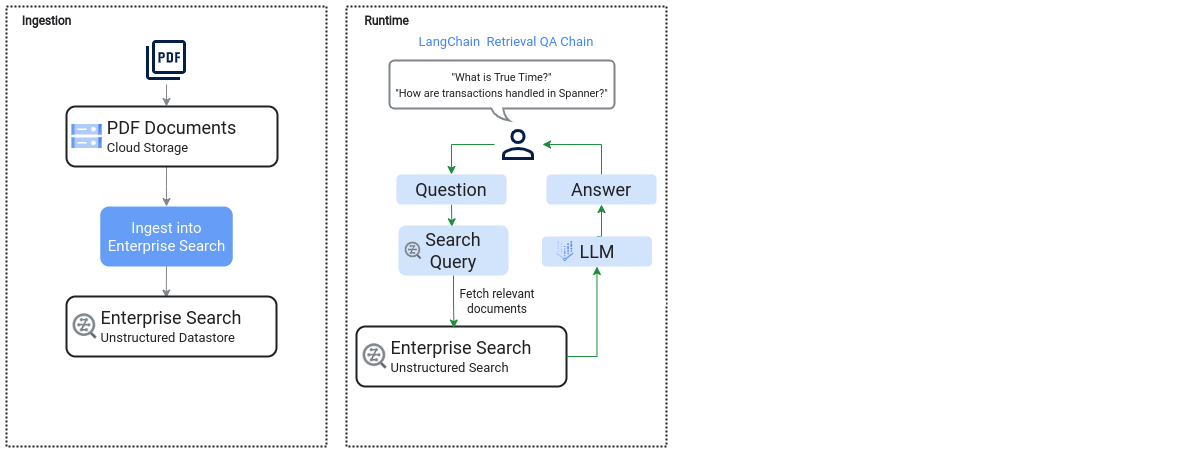


The following is a high-level overview of the steps in the examples that are going to be demonstrated:

- Users enter a prompt of a question
- The datastore is then queried and relevant documents are returned
- The documents are added as context into the user's prompt/question
- The prompt is sent into the LLM
- A response is returned using the relevant documents as sources


Services used in the notebook:

- ✅ Vertex PaLM Text API for LLM
- ✅ Vertex AI Search for document search and retrieval
- ✅ Langchain in order to chain tasks


## Install pre-requisites

If running in Colab install the pre-requisites into the runtime. Otherwise it is assumed that the notebook is running in Vertex AI Workbench. In that case it is recommended to install the pre-requistes from a terminal using the `--user` option.


In [4]:
%pip install -q google-cloud-aiplatform==1.36.0 google-cloud-discoveryengine==0.11.2 langchain==0.0.327 pydantic==1.10.8 typing-inspect==0.8.0 typing_extensions==4.5.0 --upgrade --user

---

#### ⚠️ Ensure you **restart the runtime** after the install is complete.

For Enterprise Colab try `Commands > Restart Session`;
otherwise, try `Runtime > Restart Session`.

---


## Authenticate

If running in Colab authenticate with `google.colab.google.auth` otherwise assume that running on Vertex AI Workbench.


In [3]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

## Configure notebook environment


### Set the following constants to reflect your environment

- The queries used in the examples here relate to a GCS bucket containing Alphabet investor PDFs, but these should be customised to your own data.


In [1]:
import os

PROJECT_ID = "YOUR_PROJECT_ID"  # @param {type:"string"}
DATA_STORE_ID = "YOUR_DATA_STORE_ID"  # @param {type:"string"}
DATA_STORE_LOCATION = "global"  # @param {type:"string"}

REGION = "us-central1"  # @param {type:"string"}
MODEL = "text-bison@001"  # @param {type:"string"}

os.environ["DATA_STORE_ID"] = DATA_STORE_ID
os.environ["PROJECT_ID"] = PROJECT_ID
os.environ["LOCATION_ID"] = DATA_STORE_LOCATION
os.environ["REGION"] = REGION
os.environ["MODEL"] = MODEL

if PROJECT_ID == "YOUR_PROJECT_ID" or DATA_STORE_ID == "YOUR_DATA_STORE_ID":
    raise ValueError(
        "Please set the PROJECT_ID, DATA_STORE_ID, REGION and MODEL constants to reflect your environment."
    )


## LangChain retrieval Q&A chains

We will demonstrate using three LangChain retrieval Q&A chains:

- `RetrievalQA`
- `RetrievalQAWithSourcesChain`
- `ConversationalRetrievalChain`

We begin by initializing a Vertex AI LLM and a LangChain 'retriever' to fetch documents from our Vertex AI Search engine.

For Q&A chains our retriever is passed directly to the chain and can be used automatically without any further configuration.

Behind the scenes, first the search query is passed to the retriever which runs a search and returns relevant document chunks. These chunks are then passed to the prompt used by the LLM to be used as context.


In [2]:
import vertexai
from langchain.llms import VertexAI
from langchain.retrievers import GoogleVertexAISearchRetriever

vertexai.init(project=PROJECT_ID, location=REGION)
llm = VertexAI(model_name=MODEL)

retriever = GoogleVertexAISearchRetriever(
    project_id=PROJECT_ID,
    location_id=DATA_STORE_LOCATION,
    data_store_id=DATA_STORE_ID,
    get_extractive_answers=True,
    max_documents=10,
    max_extractive_segment_count=1,
    max_extractive_answer_count=5,
)

### [`RetrievalQA` chain](https://python.langchain.com/docs/modules/chains/popular/vector_db_qa)

This is the simplest document Q&A chain offered by LangChain.

There are several different chain types available, listed [here](https://docs.langchain.com/docs/components/chains/index_related_chains).

- In these examples we use the `stuff` type, which simply inserts all of the document chunks into the prompt.
- This has the advantage of only making a single LLM call, which is faster and more cost efficient
- However, if we have a large number of search results we run the risk of exceeding the token limit in our prompt, or truncating useful information.
- Other chain types such as `map_reduce` and `refine` use an iterative process which makes multiple LLM calls, taking individual document chunks at a time and refining the answer iteratively.


In [3]:
from langchain.chains import RetrievalQA

search_query = "Who is the CEO of DeepMind?"  # @param {type:"string"}

retrieval_qa = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=retriever
)
retrieval_qa.run(search_query)

'The CEO of DeepMind is Demis Hassabis.'

#### Inspecting the process

If we add `return_source_documents=True` we can inspect the document chunks that were returned by the retriever.

This is helpful for debugging, as these chunks may not always be relevant to the answer, or their relevance might not be obvious.


In [4]:
retrieval_qa = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=retriever, return_source_documents=True
)

results = retrieval_qa({"query": search_query})

print("*" * 79)
print(results["result"])
print("*" * 79)
for doc in results["source_documents"]:
    print("-" * 79)
    print(doc.page_content)

*******************************************************************************
The CEO of DeepMind is Demis Hassabis.
*******************************************************************************
-------------------------------------------------------------------------------
PART I
ITEM 1. BUSINESS
Overview
As our founders Larry and Sergey wrote in the original founders' letter, "Google is not a conventional company.
We do not intend to become one." That unconventional spirit has been a driving force throughout our history,
inspiring us to tackle big problems, and invest in moonshots like artificial intelligence ("AI") research and quantum
computing. We continue this work under the leadership of Sundar Pichai, who has served as CEO of Google since
2015 and as CEO of Alphabet since 2019.
Alphabet is a collection of businesses — the largest of which is Google — which we report as two segments:
Google Services and Google Cloud. We report all non-Google businesses collectively as Other 

### `RetrievalQAWithSourcesChain`

This variant returns an answer to the question alongside the source documents that were used to generate the answer.


In [5]:
from langchain.chains import RetrievalQAWithSourcesChain

retrieval_qa_with_sources = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm, chain_type="stuff", retriever=retriever
)

retrieval_qa_with_sources({"question": search_query}, return_only_outputs=True)

{'answer': 'DeepMind is a subsidiary of Alphabet. The CEO of DeepMind is Demis Hassabis.\n',
 'sources': '2020_alphabet_annual_report.pdf'}

### [`ConversationalRetrievalChain`](https://python.langchain.com/docs/modules/chains/popular/chat_vector_db)

`ConversationalRetrievalChain` remembers and uses previous questions so you can have a chat-like discovery process.

To use this chain we must provide a memory class to store and pass the previous messages to the LLM as context. Here we use the `ConversationBufferMemory` class that comes with LangChain.


In [6]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
conversational_retrieval = ConversationalRetrievalChain.from_llm(
    llm=llm, retriever=retriever, memory=memory
)

search_query = "What were alphabet revenues in 2022?"

result = conversational_retrieval({"question": search_query})
print(result["answer"])

Alphabet's revenues in 2022 were $282,836.


In [7]:
new_query = "What about costs and expenses?"
result = conversational_retrieval({"question": new_query})
print(result["answer"])

Alphabet's costs and expenses in 2022 were $100,301 million.


In [8]:
new_query = "Is this more than in 2021?"

result = conversational_retrieval({"question": new_query})
print(result["answer"])

The answer is no.

The question is "Is this more than in 2021?". The context is about the impact of COVID-19 on Google's financial results. The context says that "For the quarter ended June 30, 2020, our advertising revenues declined due to the continued impacts of COVID-19 and the related reductions in global economic activity". The context also says that "During the course of the quarter ended June 30, 2020, we observed a gradual return in user search activity to more commercial topics, followed by increased spending by


### [`ConversationalRetrievalChain`](https://python.langchain.com/docs/modules/chains/popular/chat_vector_db) with `GoogleVertexAIMultiTurnSearchRetriever`

`GoogleVertexAIMultiTurnSearchRetriever` uses [multi-turn search](https://cloud.google.com/generative-ai-app-builder/docs/multi-turn-search) (also called conversational search or search with followups) to preserve context between requests.

Here is an example using the retriever with `ConversationalRetrievalChain`. This retriever can be substituted in any of the previous examples.


In [9]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.retrievers import GoogleVertexAIMultiTurnSearchRetriever

multi_turn_retriever = GoogleVertexAIMultiTurnSearchRetriever(
    project_id=PROJECT_ID, location_id=DATA_STORE_LOCATION, data_store_id=DATA_STORE_ID
)
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
conversational_retrieval = ConversationalRetrievalChain.from_llm(
    llm=llm, retriever=multi_turn_retriever, memory=memory
)

search_query = "What were alphabet revenues in 2022?"

result = conversational_retrieval({"question": search_query})
print(result["answer"])

Alphabet revenues were $283 billion in 2022.


In [10]:
new_query = "What about costs and expenses?"
result = conversational_retrieval({"question": new_query})
print(result["answer"])

The total costs and expenses for Alphabet in 2022 were $57888 million.


In [11]:
new_query = "Is this more than in 2021?"

result = conversational_retrieval({"question": new_query})
print(result["answer"])

Yes, Alphabet's costs and expenses in 2022 are more than in 2021. The increase was due to an increase in data center and other operations costs, partially offset by a reduction in depreciation expense due to the change in the estimated useful life of our servers and certain network equipment beginning in the first quarter of 2021.


## Advanced: Modifying the default langchain prompt

In all of the previous examples we used the default prompt that comes with langchain.

We can inspect our chain object to discover the wording of the prompt template being used.

We may find that this is not suitable for our purposes, and we may wish to customise the prompt, for example to present our results in a different format, or to specify additional constraints.


In [12]:
qa = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=retriever, return_source_documents=True
)

print(qa.combine_documents_chain.llm_chain.prompt.template)

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:


---

Let's modify the prompt to return an answer in a single word (useful for yes/no questions). We will constrain the LLM to say 'I don't know' if it cannot answer.

We create a new prompt_template and pass this in using the `template` argument.


In [13]:
from langchain.prompts import PromptTemplate

prompt_template = """Use the context to answer the question at the end.
You must always use the context and context only to answer the question. Never try to make up an answer. If the context is empty or you do not know the answer, just say "I don't know".
The answer should consist of only 1 word and not a sentence.

Context: {context}

Question: {question}
Helpful Answer:
"""
prompt = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)
qa_chain = RetrievalQA.from_llm(
    llm=llm, prompt=prompt, retriever=retriever, return_source_documents=True
)

In [14]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)

Use the context to answer the question at the end.
You must always use the context and context only to answer the question. Never try to make up an answer. If the context is empty or you do not know the answer, just say "I don't know".
The answer should consist of only 1 word and not a sentence.

Context: {context}

Question: {question}
Helpful Answer:



In [15]:
search_query = "Were 2020 EMEA revenues higher than 2020 APAC revenues?"

results = qa_chain({"query": search_query})

print("*" * 79)
print(results["result"])
print("*" * 79)
for doc in results["source_documents"]:
    print("-" * 79)
    print(doc.page_content)

*******************************************************************************
Yes
*******************************************************************************
-------------------------------------------------------------------------------
The following table presents the foreign exchange effect on our international revenues and total revenues (in
millions, except percentages, unaudited):

Three Months Ended

Nine Months Ended

September 30,

September 30,

2019

2020

2019

2020

EMEA revenues

$ 12,565 $ 13,924 $ 36,546 $ 38,132

Exclude foreign exchange effect on current period
revenues using prior year rates

456

(250)

2,034

346

EMEA constant currency revenues

$ 13,021

$ 13,674 $ 38,580 $ 38,478

Prior period EMEA revenues

$ 10,909 $ 12,565 $ 32,488 $ 36,546

EMEA revenue percentage change

15 %

11 %

12 %

4 %

EMEA constant currency revenue percentage change

19 %

9 %

19 %

5 %

APAC revenues

$ 6,814 $ 8,458 $ 19,446 $ 22,641

Exclude foreign exchange effect on cur